In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random
import cv2
import math
import shutil
from skimage import io
import os
from moviepy.editor import ImageSequenceClip

from tqdm.auto import tqdm
from dataloading.nvidia import NvidiaCropWide, Normalize, NvidiaDataset
from network import WaypointsNet

import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import math
import cv2
import shutil
from skimage import io
import os
from moviepy.editor import ImageSequenceClip


def draw_steering_angle(frame, steering_angle, steering_wheel_radius, steering_position, size, color):
    steering_angle_rad = math.radians(steering_angle)
    x = steering_wheel_radius * np.cos(np.pi / 2 + steering_angle_rad)
    y = steering_wheel_radius * np.sin(np.pi / 2 + steering_angle_rad)
    cv2.circle(frame, (steering_position[0] + int(x), steering_position[1] - int(y)), size, color, thickness=-1)
    
def draw_frames(dataset, predicted_angles, predicted_speed, temp_frames_folder):
    
    for frame_index, data in tqdm(enumerate(dataset), total=len(dataset)):
        frame = data["image"].permute(1, 2, 0).cpu().numpy()
        true_angle = math.degrees(data["steering_angle"])
        pred_angle = math.degrees(predicted_angles[frame_index])
        
        true_speed = data["vehicle_speed"] * 3.6
        pred_speed = predicted_speed[frame_index] * 3.6
        
        cv2.putText(frame, 'True: {:.2f} deg, {:.2f} km/h'.format(true_angle, true_speed), (10, 1150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2,
                    cv2.LINE_AA)
        cv2.putText(frame, 'Pred: {:.2f} deg, {:.2f} km/h'.format(pred_angle, pred_speed), (10, 1200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2,
                    cv2.LINE_AA)
    
        radius = 200
        steering_pos = (960, 1200)
        cv2.circle(frame, steering_pos, radius, (255, 255, 255), 7)
        
        cv2.rectangle(frame, (905, 1200), (955, 1200-int(3*true_speed)), (0,255,0), cv2.FILLED)
        cv2.rectangle(frame, (965, 1200), (1015, 1200-int(3*pred_speed)), (255, 0,0), cv2.FILLED)
        

        draw_steering_angle(frame, true_angle, radius, steering_pos, 13, (0, 255, 0))
        draw_steering_angle(frame, pred_angle, radius, steering_pos, 9, (255, 0, 0))
            
        io.imsave(f"{temp_frames_folder}/{frame_index + 1:05}.jpg", frame)
        

def convert_frames_to_video(frames_folder, output_video_path, fps=25):
    output_folder = Path(os.path.split(output_video_path)[:-1][0])
    output_folder.mkdir(parents=True, exist_ok=True)

    p = Path(frames_folder).glob('**/*.jpg')
    image_list = sorted([str(x) for x in p if x.is_file()])

    print("Creating video {}, FPS={}".format(frames_folder, fps))
    clip = ImageSequenceClip(image_list, fps=fps)
    clip.write_videofile(output_video_path)

In [12]:
root_path = Path("/home/romet/projects/ut/wp4/dataset")
valid_paths = [root_path / "2021-05-28-15-19-48_e2e_sulaoja_20_30"]
validset = NvidiaDataset(valid_paths, camera="front_wide")

In [13]:
from dataloading.nvidia import NvidiaCropWide, Normalize, NvidiaDataset
from trainer import Trainer
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = f"models/1-pilotnet-waypoints-v3"
wp_model = WaypointsNet()
wp_model.load_state_dict(torch.load(f"{model_name}/best.pt"))
wp_model.to(device)

tr = transforms.Compose([NvidiaCropWide(), Normalize()])
validset_tr = NvidiaDataset(valid_paths, tr)
#validset_tr.frames = validset_tr.frames[1000:1100]
waypoints = trainer.predict(wp_model, validset_tr)

  0%|          | 0/163 [00:00<?, ?it/s]

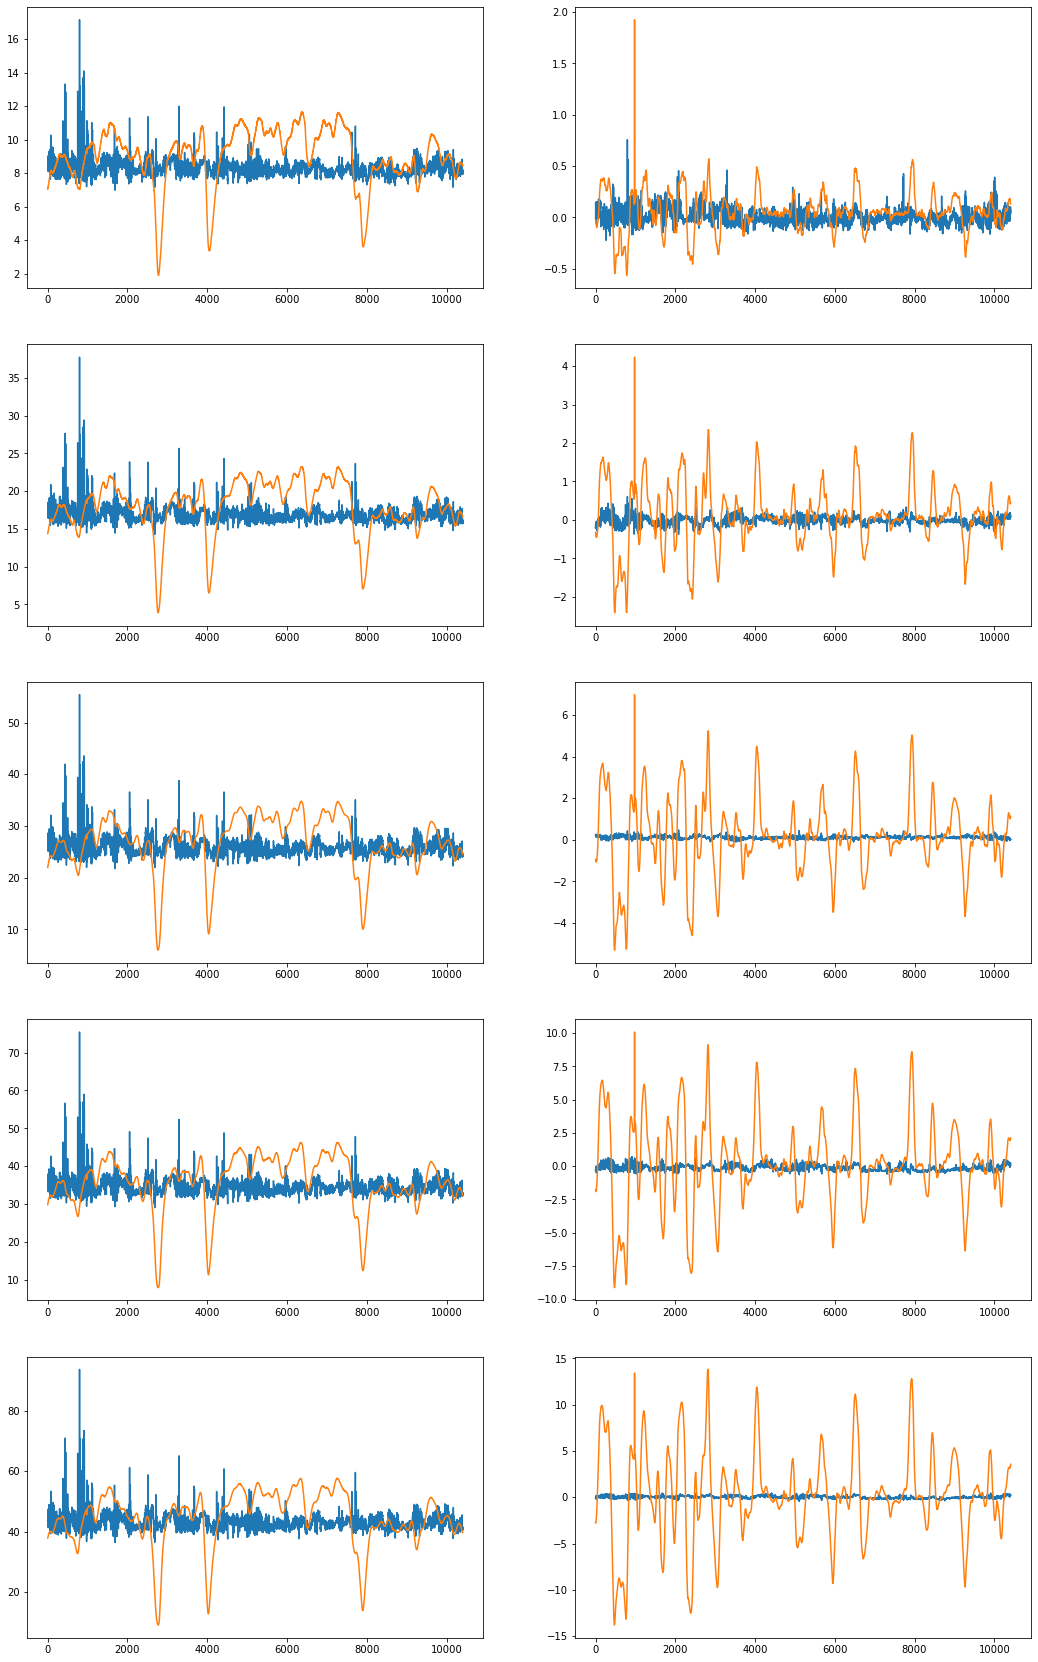

In [14]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(18, 30))

ax1.plot([wp[0] for wp in waypoints])
ax1.plot(validset.frames["x_1_offset"].to_numpy())

ax2.plot([wp[1] for wp in waypoints])
ax2.plot(validset.frames["y_1_offset"].to_numpy())

ax3.plot([wp[2] for wp in waypoints])
ax3.plot(validset.frames["x_2_offset"].to_numpy())

ax4.plot([wp[3] for wp in waypoints])
ax4.plot(validset.frames["y_2_offset"].to_numpy())

ax5.plot([wp[4] for wp in waypoints])
ax5.plot(validset.frames["x_3_offset"].to_numpy())

ax6.plot([wp[5] for wp in waypoints])
ax6.plot(validset.frames["y_3_offset"].to_numpy())

ax7.plot([wp[6] for wp in waypoints])
ax7.plot(validset.frames["x_4_offset"].to_numpy())

ax8.plot([wp[7] for wp in waypoints])
ax8.plot(validset.frames["y_4_offset"].to_numpy())

ax9.plot([wp[8] for wp in waypoints])
ax9.plot(validset.frames["x_5_offset"].to_numpy())

ax10.plot([wp[9] for wp in waypoints])
ax10.plot(validset.frames["y_5_offset"].to_numpy())

In [ ]:
# for wp in waypoints[4100:4200]:
#     print(f"[{wp[0]:0.4f}, {wp[1]:0.4f}], [{wp[2]:0.4f}, {wp[3]:0.4f}], [{wp[4]:0.4f}, {wp[5]:0.4f}]")

In [ ]:
# for index, row in validset_tr.frames[4100:4200].iterrows():
#     wp = [row["x_1_offset"], row["y_1_offset"], 
#           row["x_2_offset"], row["y_2_offset"],
#           row["x_3_offset"], row["y_3_offset"]]
#     print(f"[{wp[0]:0.4f}, {wp[1]:0.4f}], [{wp[2]:0.4f}, {wp[3]:0.4f}], [{wp[4]:0.4f}, {wp[5]:0.4f}]")

In [ ]:
temp_frames_folder = Path("./temp_frames")
shutil.rmtree(temp_frames_folder, ignore_errors=True)
temp_frames_folder.mkdir()

draw_frames(validset, steering_predictions, speed_predictions, temp_frames_folder)
output_video = "output/test.mp4"
convert_frames_to_video(temp_frames_folder, output_video, fps=30.0)

shutil.rmtree(temp_frames_folder, ignore_errors=True)

In [ ]:
from IPython.display import HTML


HTML(f"""
<video width="640" height="480" controls>
  <source src="{output_video}" type="video/mp4">
</video>
""")